# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [2]:
#load data
df = pd.read_csv('insurance - insurance.csv')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


# Q1. Do smokers have higher insurance charges than non-smokers?

## Hypothesis

- Null hypothesis: There is no difference in insurance charges between smokers and non-smokers
- Alternative hypothesis: Smokers have higher insurance charges than non-smokers

In [3]:
#sample sizes
df['smoker'].value_counts()

no     1064
yes     274
Name: smoker, dtype: int64

- There are two groups: smokers and non smokers
- The insurance charge is numerical
- Therefore, here I use 2 sample T-test

In [4]:
#split the data
smokers = df.loc[df['smoker']== 'yes', 'charges']
no_smokers = df.loc[df['smoker']=='no', 'charges']
no_smokers

1        1725.55230
2        4449.46200
3       21984.47061
4        3866.85520
5        3756.62160
           ...     
1332    11411.68500
1333    10600.54830
1334     2205.98080
1335     1629.83350
1336     2007.94500
Name: charges, Length: 1064, dtype: float64

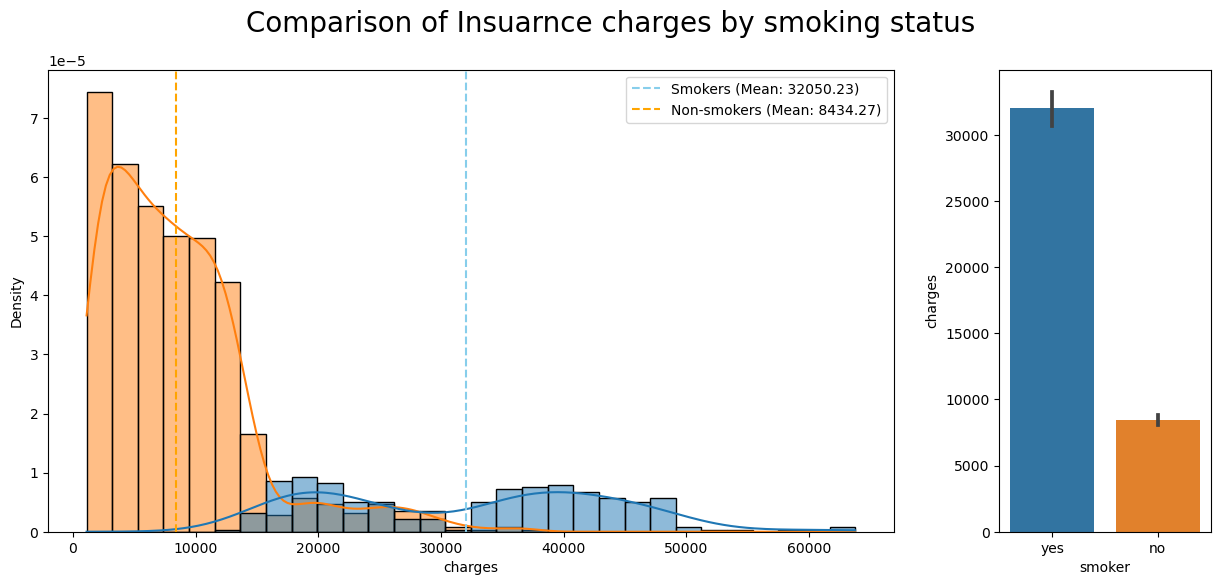

In [5]:
#visualization
fig, ax = plt.subplots(ncols = 2, figsize=(15,6), gridspec_kw={'width_ratios':[0.8,0.2]})

sns.histplot(data =df, x = 'charges', hue = 'smoker', ax= ax[0], 
             stat ='density', kde = True)
ax[0].axvline(np.mean(smokers), 
              label = f'Smokers (Mean: {np.mean(smokers):.2f})', 
              ls = '--', color = 'skyblue')
ax[0].axvline(np.mean(no_smokers), 
              label = f'Non-smokers (Mean: {np.mean(no_smokers):.2f})', 
              ls = '--', color = 'orange')

ax[0].legend()

sns.barplot(data=df, x='smoker', y='charges', ax= ax[1])

fig.suptitle('Comparison of Insuarnce charges by smoking status', fontsize = 20);

## Testing for outliers

In [6]:
#outliers for smokers
zscore_smokers = stats.zscore(smokers)
outliers_smokers = abs(zscore_smokers) >3
np.sum(outliers_smokers)

0

In [7]:
#outliers for non-smokers
zscore_no_smokers = stats.zscore(no_smokers)
outliers_no_smokers = abs(zscore_no_smokers) >3
np.sum(outliers_no_smokers)

24

In [8]:
#remove outliers from non-smokers
no_smokers = no_smokers[(abs(zscore_no_smokers)<3)]

Now there are no outliers in data

## Test Each Group for Normality

In [9]:
#normality test for smokers
results_smokers = stats.normaltest(smokers)
results_smokers

NormaltestResult(statistic=61.03941356533816, pvalue=5.564930630036463e-14)

In [10]:
#normality test for non-smokers
results_no_smokers = stats.normaltest(no_smokers)
results_no_smokers

NormaltestResult(statistic=163.80367047789198, pvalue=2.6945416315543976e-36)

In both of the tests, p value is lower than 0.05 which means the data is not normally distributed. Since both group sizes are larger than 15 we can safely ignore the normality assumption.

## Testing for Equal Variance with Levene's test

In [11]:
results = stats.levene(smokers, no_smokers)
results

LeveneResult(statistic=520.7468821724297, pvalue=2.4247238784347824e-97)

Since our p-value is lower than 0.05, reject the null hypothesis that the samples are not coming from populations with equal variances. So I will use equal_var= False for independent T-test.

## Independent t-test

In [12]:
t_result = stats.ttest_ind(smokers, no_smokers, equal_var= False)
t_result

Ttest_indResult(statistic=33.732305987092516, pvalue=2.575322662587431e-104)

Since p value is lower than 0.05, reject null hypothesis that smokers have higher insurance charges than non-smokers 

# Q2. Are men more likely to smoke than women?

- This problem asks to compare a binary target category vs categorical groups
- Therefore, here I use Chi-squared test

## Hypothesis:

- Null Hypothesis: There is no relationship between gender and smoking status.
- Alternative Hypothesis: Men are more likely to smoke than women.

Text(0.5, 1.0, 'Smoking status by sex')

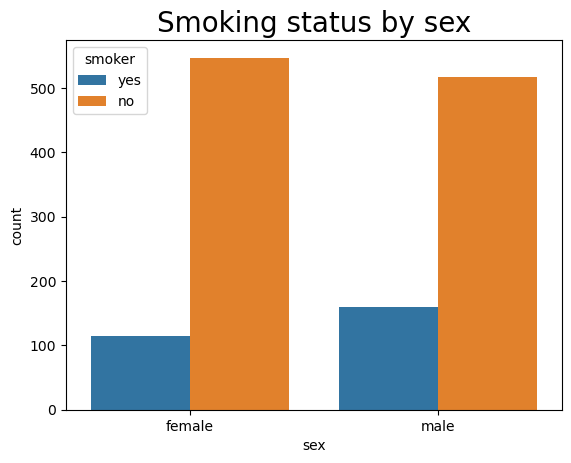

In [13]:
#visualization
sns.countplot(data = df, x= 'sex', hue='smoker')
plt.title('Smoking status by sex', fontsize = 20)

In [14]:
# calculate the contingency table
table = pd.crosstab(df['sex'], df['smoker'])
table

smoker,no,yes
sex,,
female,547,115
male,517,159


In [15]:
# calculate the contingency table
chi_result = stats.chi2_contingency(table)
chi2, p, deg_free, expected_vals = chi_result

In [16]:
#p value
print(p)

0.006548143503580696


Since the p value for this test is lower than 0.05, reject null hypothesis, which is true that men are more likely to smoke than women.

# Q3. Do different regions have different charges, on average?

## Hypothesis
- Null hypothesis: The average insurance charges are not changing in different regions
- Alternative hypothesis: different regions have different average insurance charges

In [17]:
#number of regions
df['region'].value_counts()

southeast    364
southwest    325
northwest    325
northeast    324
Name: region, dtype: int64

Text(0.5, 1.0, 'Average Charge in different regions')

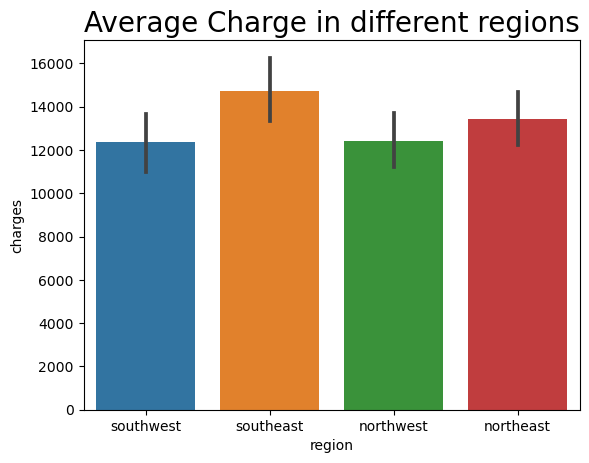

In [18]:
#visualization
sns.barplot(data=df, x= 'region', y= 'charges')
plt.title('Average Charge in different regions', fontsize = 20)

- Since, the dataset has 4 different regions (samples) and the insurance charge is numerical, I choose ANOVA

In [19]:
#create a dictionary with 4 regions
samples = {}

for i in df['region'].unique():
    data = df.loc[df['region']==i, 'charges'].copy()
    
    samples[i] = data

In [20]:
samples.keys()

dict_keys(['southwest', 'southeast', 'northwest', 'northeast'])

In [21]:
samples.values()

dict_values([0       16884.92400
12       1826.84300
15       1837.23700
18      10602.38500
19      36837.46700
           ...     
1316     1731.67700
1329    10325.20600
1331    10795.93733
1332    11411.68500
1336     2007.94500
Name: charges, Length: 325, dtype: float64, 1        1725.5523
2        4449.4620
5        3756.6216
6        8240.5896
11      27808.7251
           ...    
1322    12981.3457
1323    43896.3763
1327     9377.9047
1330    12629.1656
1335     1629.8335
Name: charges, Length: 364, dtype: float64, 3       21984.47061
4        3866.85520
7        7281.50560
9       28923.13692
24       6203.90175
           ...     
1319     7201.70085
1320     5425.02335
1324     4239.89265
1333    10600.54830
1337    29141.36030
Name: charges, Length: 325, dtype: float64, 8        6406.41070
10       2721.32080
16      10797.33620
17       2395.17155
20      13228.84695
           ...     
1321    28101.33305
1325    13143.33665
1326     7050.02130
1328    22395.74424
1334  

## Normality Test

In [22]:
norm_results ={}

for i, data in samples.items():
    stat, p = stats.normaltest(data)
    norm_results[i] = {'n': len(data),
                       'p': p,
                       'test stat': stat}
    
norm_results_df = pd.DataFrame(norm_results).T
norm_results_df

,n,p,test stat
southwest,325.0,6.125298e-23,102.294059
southeast,364.0,4.953297e-15,65.877446
northwest,325.0,5.184209e-24,107.232850
northeast,324.0,1.455431e-19,86.747629


In [23]:
### checking the significance with pandas
norm_results_df['sig'] = norm_results_df['p']<0.05
norm_results_df

,n,p,test stat,sig
southwest,325.0,6.125298e-23,102.294059,True
southeast,364.0,4.953297e-15,65.877446,True
northwest,325.0,5.184209e-24,107.232850,True
northeast,324.0,1.455431e-19,86.747629,True


All regions are not normally distributed. But for this 4 sample problem, each consist more than 15, we can safely ignore the normality assumption. 

## Equal Variance Test

In [24]:
stats.levene(*samples.values())

LeveneResult(statistic=5.559966758410606, pvalue=0.0008610590250786703)

All samples do not have equal variances too. So it requires to  select a non-parametric equivalent which is Kruskal-Wallis

In [25]:
result = stats.kruskal(*samples.values())
result

KruskalResult(statistic=4.734181215658743, pvalue=0.19232908072121002)

Since p value  is higher than 0.05, it is fail to reject the null hypothesis which is there is no difference in insurance charges for different regions.